In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from cartopy.crs import Robinson, PlateCarree
from xeofs.xarray import EOF, Rotator

In [3]:
sns.set_context('paper')

sst = xr.tutorial.open_dataset('ersstv5')['sst']

# There are some grid points with have constant values only.
# Standardization of these time series cannot work since
# the standard deviation is zero.
# Remove these grid points prior to the analysis:
minimum_std_dev = 1e-5
valid_x = sst.stack(x=['lat', 'lon']).std('time') > minimum_std_dev
sst = sst.stack(x=['lat', 'lon']).sel(x=valid_x).unstack()

In [4]:
eofs = []
pcs = []

# (1) Standard EOF without regularization
model = EOF(sst, dim=['time'], norm=True, weights='coslat')
model.solve()
eofs.append(model.eofs())
pcs.append(model.pcs())

# (2) Varimax-rotated EOF analysis
rot_var = Rotator(model, n_rot=50, power=1)
eofs.append(rot_var.eofs())
pcs.append(rot_var.pcs())

# (3) Promax-rotated EOF analysis
rot_pro = Rotator(model, n_rot=50, power=4)
eofs.append(rot_pro.eofs())
pcs.append(rot_pro.pcs())

Create figure showing the first 6 modes for all 3 cases. While the first mode is very similar in all three cases the subsequent modes of the standard solution exhibit dipole and tripole-like patterns. Under Varimax and Promax rotation, these structures completely disappear suggesting that these patterns were mere artifacts due to the orthogonality.

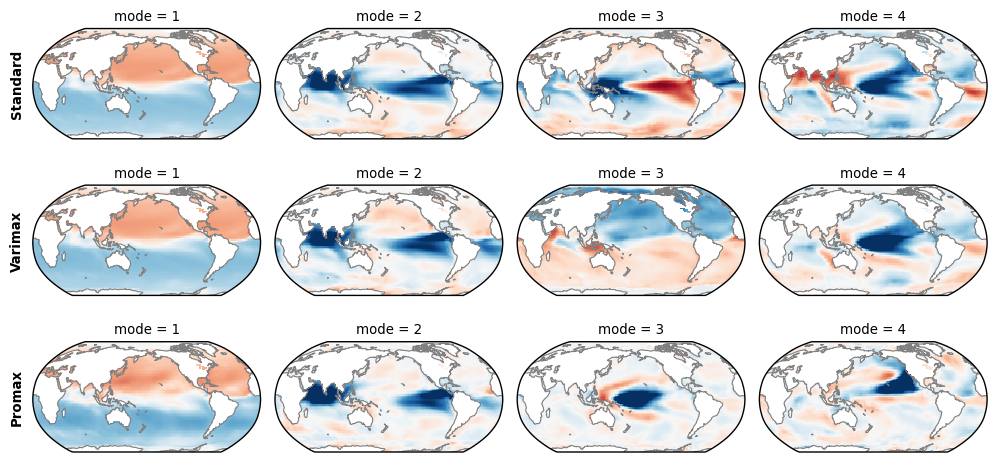

In [6]:
proj = Robinson(central_longitude=180)
kwargs = {
    'cmap' : 'RdBu', 'transform': PlateCarree(), 'vmin': -.03, 'vmax': +.03,
    'add_colorbar': False

}

fig = plt.figure(figsize=(10, 5))
gs = GridSpec(3, 4)
ax_std = [fig.add_subplot(gs[0, i], projection=proj) for i in range(4)]
ax_var = [fig.add_subplot(gs[1, i], projection=proj) for i in range(4)]
ax_pro = [fig.add_subplot(gs[2, i], projection=proj) for i in range(4)]

for i, (a0, a1, a2) in enumerate(zip(ax_std, ax_var, ax_pro)):
    mode = i + 1
    a0.coastlines(color='.5')
    a1.coastlines(color='.5')
    a2.coastlines(color='.5')
    eofs[0].sel(mode=mode).plot(ax=a0, **kwargs)
    eofs[1].sel(mode=mode).plot(ax=a1, **kwargs)
    eofs[2].sel(mode=mode).plot(ax=a2, **kwargs)

title_kwargs = dict(rotation=90, va='center', weight='bold')
ax_std[0].text(-.1, .5, 'Standard', transform=ax_std[0].transAxes, **title_kwargs)
ax_var[0].text(-.1, .5, 'Varimax', transform=ax_var[0].transAxes, **title_kwargs)
ax_pro[0].text(-.1, .5, 'Promax', transform=ax_pro[0].transAxes, **title_kwargs)

plt.tight_layout()
plt.savefig('rotated_eof.jpg', dpi=200)